# MLOps Tech Test

This is a simple tech test asking you to write a Python program with the purpose to verify your learning capability and
Python skills. Please note that we do expect you to have sufficient Python skills but not on the specific tech stack
required. The expectation is that if you don't know about something, learn how to use it by reading and trying to solve
the problem. There are plenty of tutorials and examples online, and you can Google as much as you like to complete the
task.

_Be ready to explain what you have done, especially when third-party code has been used in your solution._

## Overall requirement

Once the solution is finished, please store it in a public Git repository on GitHub (this is free to create) and share
the link with us.

## Task 1

Write a Python script to:

1. Read the input
   from

```shell
gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv
```

and load it
in a Pandas Dataframe.

2. Split the dataset into 3 splits: train, validation and test with ratios of 60 (train) / 20 (validation) / 20 (test)
3. Perform any feature engineering you might find useful. It's not required that you create any new features.
4. Train an ML model using XGBoost (or equivalent) to predict whether a pet will be adopted or not, `Adopted` is the
   target feature. You will need to use the validation to assess early stopping. You won't need to hypertune any
   parameters, the default parameters will be sufficient, with the exception of the number of trees which gets tuned by
   the early stopping mechanism.
5. The script needs to log to the user the performances of the model in the test set in terms of F1 Score, Accuracy,
   Recall.

Save the model into `artifacts/model` and ensure the folder is <b>not</b> git ignored.

## Task 2

Write a Python script to:

1. Load the data
   from

```shell
gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv
```

2. Uses the model you trained in the previous step to score all the rows in the CSV.
3. Save the output into `output/results.csv` and make sure all files in the `output/` directory <b>are</b> git ignored.
4. Add unit tests to the prediction function.

The output needs to follow the following format:

```csv
Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Adopted_prediction
Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes, No
```


### Import data

In [63]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from google.cloud import storage
import io

def create_storage_client():
    """
    Creates a client to interact with the Google Cloud Storage API.
    """
    return storage.Client()

def download_csv_from_gcs(storage_client, bucket_name, file_name):
    """
    Downloads a CSV file from Google Cloud Storage (GCS) and returns its contents as a string.
    """
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_name)

    file_content = blob.download_as_string()

    return file_content

def read_csv_from_string(file_content):
    """
    Reads a CSV file from a string and returns its contents as a pandas DataFrame.
    """
    df = pd.read_csv(io.StringIO(file_content.decode("utf-8")))

    return df


In [5]:
storage_client = create_storage_client()

In [6]:
bucket_name = "cloud-samples-data"
file_name = "ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv"

In [7]:
file_content = download_csv_from_gcs(storage_client, bucket_name, file_name)

In [8]:
df_petfinder = read_csv_from_string(file_content)

In [6]:
df_petfinder

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,Yes
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,Yes
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,No


### **Exploratory Data Analysis**

#### **Type**

In [14]:
df_petfinder["Type"].unique()

array(['Cat', 'Dog'], dtype=object)

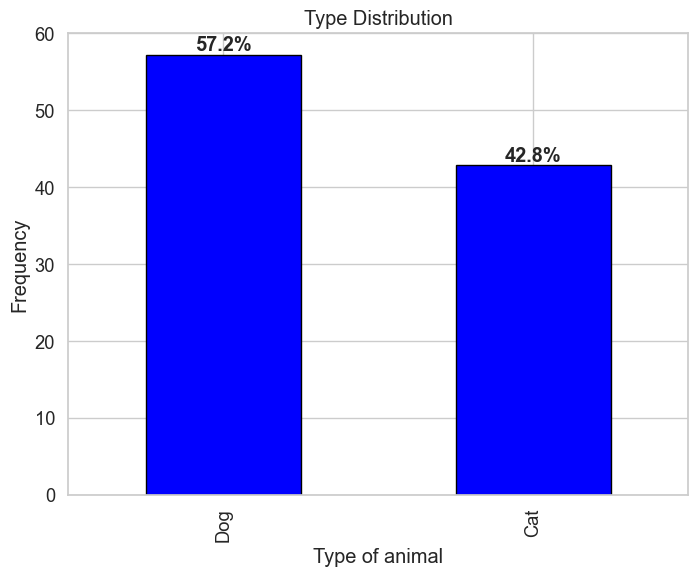

In [45]:
df_type = df_petfinder["Type"].value_counts(normalize=True) * 100
ax = df_type.plot(kind='bar', figsize=(8, 6), color='blue', edgecolor='black')
plt.xlabel('Type of animal')
plt.ylabel('Frequency')
plt.title('Type Distribution')
for i in ax.containers[0]:
    height = i.get_height()
    ax.text(i.get_x() + i.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

#### **Age Range**

In [16]:
import matplotlib.pyplot as plt


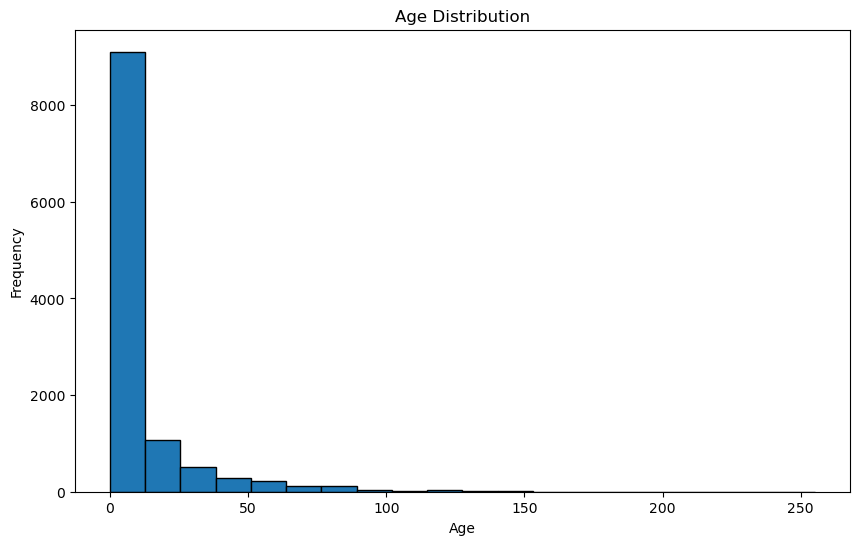

In [17]:
df_age = df_petfinder['Age'].hist(bins=20, grid=False, edgecolor='black', figsize=(10, 6))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [18]:
import seaborn as sns


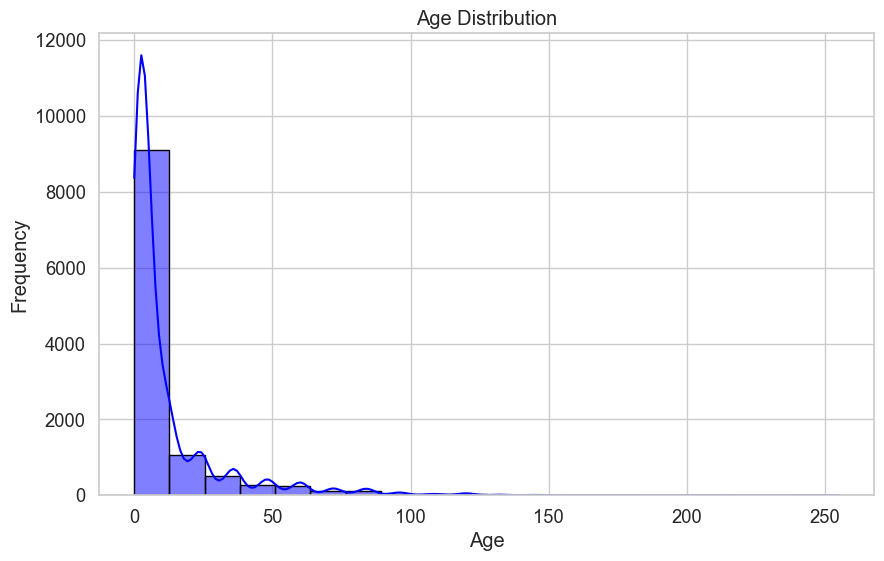

In [21]:
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.histplot(df_petfinder['Age'], bins=20, kde=True, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

#### **Breed1**

In [50]:
df_petfinder["Breed1"].unique()

array(['Tabby', 'Domestic Medium Hair', 'Mixed Breed',
       'Domestic Short Hair', 'Domestic Long Hair', 'Terrier', 'Persian',
       'Rottweiler', 'Jack Russell Terrier', 'Shih Tzu',
       'Labrador Retriever', 'Silky Terrier', 'Bombay', 'Husky',
       'Schnauzer', 'Golden Retriever', 'Siberian Husky', 'Collie',
       'German Shepherd Dog', 'Siamese', 'Calico',
       'American Staffordshire Terrier', 'Turkish Van',
       'Doberman Pinscher', 'Oriental Short Hair', 'Beagle', 'Ragdoll',
       'Cocker Spaniel', 'Poodle', 'Black Labrador Retriever', 'Bengal',
       'Shar Pei', 'Spitz', 'Birman', 'Belgian Shepherd Malinois',
       'American Shorthair', 'Belgian Shepherd Laekenois', '0',
       'Jack Russell Terrier (Parson Russell Terrier)', 'Shepherd',
       'Corgi', 'Pit Bull Terrier', 'Oriental Tabby',
       'Miniature Pinscher', 'Manx', 'Boxer', 'Dachshund', 'Chihuahua',
       'Snowshoe', 'Rat Terrier', 'Tiger', 'Silver', 'Maine Coon',
       'German Pinscher', 'Russian Bl

In [52]:
category_target_count = df_petfinder.groupby(['Breed1', 'Adopted']).size().reset_index(name='count')
category_target_count.sort_values('Breed1')

,Breed1,Adopted,count
0,0,No,2
1,0,Yes,2
2,Abyssinian,No,4
3,Abyssinian,Yes,16
4,Akita,No,1
...,...,...,...
260,White German Shepherd,Yes,2
261,Wirehaired Terrier,No,1
262,Wirehaired Terrier,Yes,1
263,Yellow Labrador Retriever,Yes,12


#### **Gender**

In [24]:
df_petfinder["Gender"].unique()

array(['Male', 'Female'], dtype=object)

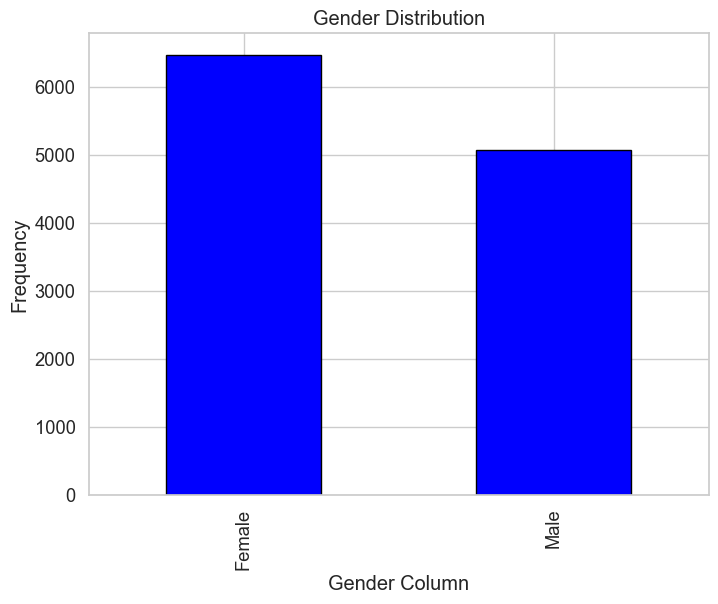

In [39]:
df_petfinder["Gender"].value_counts().plot(kind='bar', figsize=(8, 6), color='blue', edgecolor='black')
plt.xlabel('Gender Column')
plt.ylabel('Frequency')
plt.title('Gender Distribution')
plt.show()

#### **Color1**

In [25]:
df_petfinder["Color1"].unique()

array(['Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'],
      dtype=object)

#### **Color2**

In [26]:
df_petfinder["Color2"].unique()

array(['White', 'Brown', 'No Color', 'Gray', 'Cream', 'Golden', 'Yellow'],
      dtype=object)

In [53]:
df_petfinder["Color2"].value_counts()

No Color    3968
White       2920
Brown       2203
Cream        788
Gray         659
Yellow       535
Golden       464
Name: Color2, dtype: int64

#### **MaturitySize**

In [27]:
df_petfinder["MaturitySize"].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

#### **FurLength**

In [30]:
df_petfinder["FurLength"].unique()

array(['Short', 'Medium', 'Long'], dtype=object)

#### **Vaccinated**

In [31]:
df_petfinder["Vaccinated"].unique()

array(['No', 'Not Sure', 'Yes'], dtype=object)

#### **Sterilized**

In [32]:
df_petfinder["Sterilized"].unique()

array(['No', 'Not Sure', 'Yes'], dtype=object)

#### **Health**

In [33]:
df_petfinder["Health"].unique()

array(['Healthy', 'Minor Injury', 'Serious Injury'], dtype=object)

#### **Fee**

In [34]:
df_petfinder["Fee"].unique()

array([ 100,    0,  150,  300,   50,   10,    1,   30,  750,  400,   80,
         20,  250,  200,  120,  500,   15,    5,  350,    8,    9,  550,
         90,  110,  220,   70,   89,  280,   40,  600,   38, 1000,   60,
        180,   25,   65,  700,  170,  480,  155,  450,   48,  299,  160,
        688,  270,  650,   99,   35,   45,  210,  188,  380,  108,  390,
         59,   88,  800,  235, 2000,  599,  125,  499,   75,  190])

#### **PhotoAmt**

In [35]:
df_petfinder["PhotoAmt"].unique()

array([ 1,  2,  7,  8,  3,  6,  0, 19, 11,  5,  4, 13, 18, 12, 10,  9, 24,
       14, 15, 23, 28, 20, 27, 26, 16, 30, 29, 22, 25, 21, 17])

#### **Adopted**

In [36]:
df_petfinder["Adopted"].value_counts()

Yes    8457
No     3080
Name: Adopted, dtype: int64

In [38]:
import matplotlib.pyplot as plt


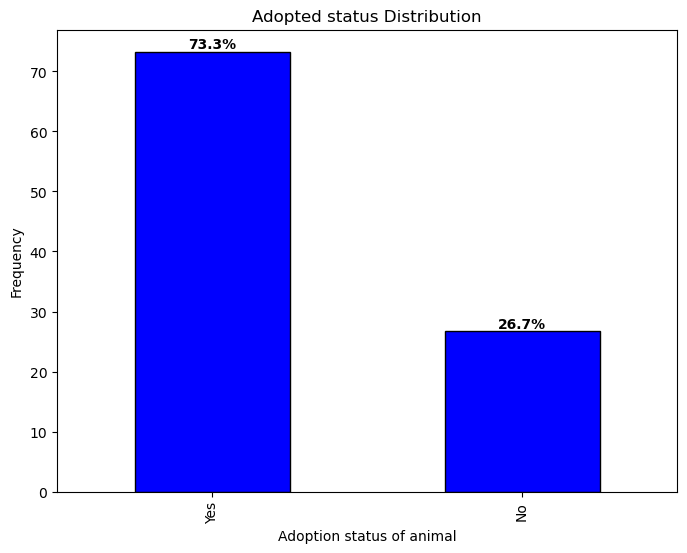

In [39]:
df_adopted= df_petfinder["Adopted"].value_counts(normalize=True) * 100
ax = df_adopted.plot(kind='bar', figsize=(8, 6), color='blue', edgecolor='black')
plt.xlabel('Adoption status of animal')
plt.ylabel('Frequency')
plt.title('Adopted status Distribution')
for i in ax.containers[0]:
    height = i.get_height()
    ax.text(i.get_x() + i.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

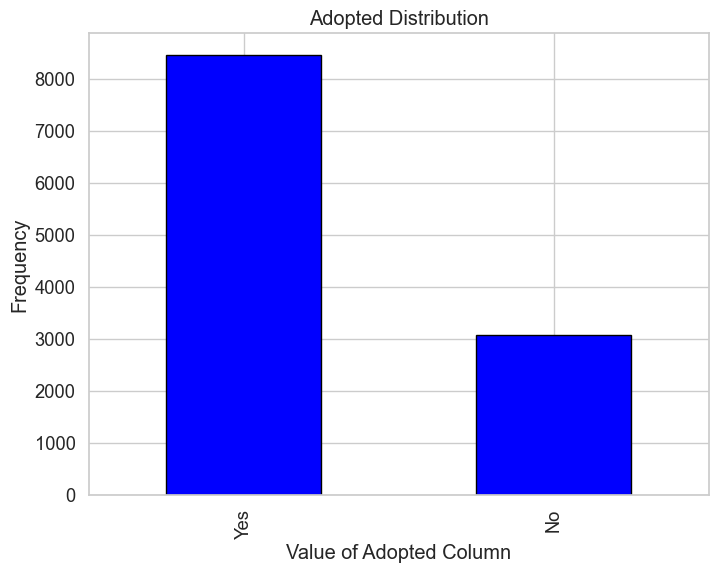

In [37]:
df_petfinder["Adopted"].value_counts().plot(kind='bar', figsize=(8, 6), color='blue', edgecolor='black')
plt.xlabel('Value of Adopted Column')
plt.ylabel('Frequency')
plt.title('Adopted Distribution')
plt.show()

Columns:
1. Type: 1-hot-encode
2. Age
3. Breed1: Feature Hashing
4. Gender: 1 hot encode
5. color1: Label Encoding, 1-hot, Feature Hashing
6. Color2: Label Encoding, 1-hot, Feature Hashing
7. MaturitySize: Ordinal Encoding
8. FurLength: Ordinal Encoding
9. Vaccinated: Label Encoding, 1-hot
10. Sterilized: Label Encoding, 1-hot
11. Health: Ordinal Encoding
12. Fee
13. PhotoAmt
14. Adopted

#### **One-hot Encode Type**

In [7]:
df_type_encoded = pd.get_dummies(df_petfinder, columns=['Type'], prefix='Type')
df_type_encoded

,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog
0,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes,1,0
1,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0
2,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes,0,1
3,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes,0,1
4,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No,0,1
11533,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,Yes,1,0
11534,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,Yes,0,1
11535,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,No,1,0


#### **One-hot encode Gender**

In [ ]:
df_gender_encoded = pd.get_dummies(df_type_encoded, columns=['Gender'], prefix='Gender')
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,Black,White,Small,Short,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,Cream,Gray,Medium,Short,No,No,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,Black,White,Small,Long,Yes,No,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,No,1,0,1,0


#### **Label Encode Color1**

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_gender_encoded['Color1'] = encoder.fit_transform(df_gender_encoded['Color1'])

In [13]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,White,Small,Short,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,White,Medium,Medium,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,No Color,Medium,Short,No,No,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,Gray,Medium,Short,No,No,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,White,Small,Long,Yes,No,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,White,Small,Short,Yes,Yes,Healthy,0,3,No,1,0,1,0


#### **Label Encode Color2**

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_gender_encoded['Color2'] = encoder.fit_transform(df_gender_encoded['Color2'])

In [15]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,Small,Short,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,Medium,Medium,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,Medium,Short,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,Medium,Short,No,No,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,Medium,Medium,Not Sure,No,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,Medium,Short,No,No,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,Small,Long,Yes,No,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,Small,Short,Yes,Yes,Healthy,0,3,No,1,0,1,0


#### **Ordinal Encoding of MaturitySize**

In [16]:
df_gender_encoded["MaturitySize"].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

In [18]:
from sklearn.preprocessing import OrdinalEncoder

In [19]:
encoder = OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])
df_gender_encoded['MaturitySize'] = encoder.fit_transform(df_gender_encoded[['MaturitySize']])

In [21]:
df_gender_encoded["MaturitySize"].unique()

array([0., 1., 2.])

In [20]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,0.0,Short,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,1.0,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,1.0,Medium,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,1.0,Short,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,1.0,Short,No,No,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,1.0,Medium,Not Sure,No,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,1.0,Short,No,No,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,0.0,Long,Yes,No,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,0.0,Short,Yes,Yes,Healthy,0,3,No,1,0,1,0


#### **Ordinal Encoding of FurLength**

In [22]:
df_gender_encoded["FurLength"].unique()

array(['Short', 'Medium', 'Long'], dtype=object)

In [23]:
encoder = OrdinalEncoder(categories=[['Short', 'Medium', 'Long']])
df_gender_encoded['FurLength'] = encoder.fit_transform(df_gender_encoded[['FurLength']])

In [24]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,0.0,0.0,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,1.0,1.0,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,1.0,1.0,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,1.0,0.0,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,1.0,0.0,No,No,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,1.0,1.0,Not Sure,No,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,1.0,0.0,No,No,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,0.0,2.0,Yes,No,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,0.0,0.0,Yes,Yes,Healthy,0,3,No,1,0,1,0


#### **Label Encode Vaccinated**

In [26]:
df_gender_encoded["Vaccinated"].unique()

array(['No', 'Not Sure', 'Yes'], dtype=object)

In [27]:
df_gender_encoded["Vaccinated"].value_counts()

Yes         5060
No          4962
Not Sure    1515
Name: Vaccinated, dtype: int64

In [29]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_gender_encoded['Vaccinated'] = encoder.fit_transform(df_gender_encoded['Vaccinated'])

#### **Label Encode Sterilized**

In [28]:
df_gender_encoded["Sterilized"].unique()

array(['No', 'Not Sure', 'Yes'], dtype=object)

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_gender_encoded['Sterilized'] = encoder.fit_transform(df_gender_encoded['Sterilized'])

In [31]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,0.0,0.0,0,0,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,1.0,1.0,1,1,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,1.0,1.0,2,0,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,1.0,0.0,2,0,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,1.0,0.0,0,0,Healthy,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,1.0,1.0,1,0,Healthy,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,1.0,0.0,0,0,Healthy,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,0.0,2.0,2,0,Healthy,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,0.0,0.0,2,2,Healthy,0,3,No,1,0,1,0


#### **Ordinal Encoding of Health**

In [33]:
df_gender_encoded["Health"].value_counts()

Healthy           11098
Minor Injury        409
Serious Injury       30
Name: Health, dtype: int64

In [34]:
df_gender_encoded["Health"].unique()

array(['Healthy', 'Minor Injury', 'Serious Injury'], dtype=object)

In [35]:
encoder = OrdinalEncoder(categories=[['Healthy', 'Minor Injury', 'Serious Injury']])
df_gender_encoded['Health'] = encoder.fit_transform(df_gender_encoded[['Health']])

In [36]:
df_gender_encoded

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,0.0,0.0,0,0,0.0,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,1.0,1.0,1,1,0.0,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,1.0,1.0,2,0,0.0,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,1.0,0.0,2,0,0.0,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,1.0,0.0,0,0,0.0,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,1.0,1.0,1,0,0.0,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,1.0,0.0,0,0,0.0,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,0.0,2.0,2,0,0.0,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,0.0,0.0,2,2,0.0,0,3,No,1,0,1,0


#### **Rewrites**

In [19]:
columns_to_be_one_hot_encoded = ["Type","Gender"]
columns_to_be_label_encoded = ["Vaccinated","Sterilized","Color1","Color2"]
columns_to_be_ordinally_encoded = {"Health":['Healthy', 'Minor Injury', 'Serious Injury'],"FurLength":['Short', 'Medium', 'Long'],"MaturitySize":['Small', 'Medium', 'Large']}

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


def one_hot_encode_columns(df,columns_to_be_one_hot_encoded):
    for column in columns_to_be_one_hot_encoded:
        df = pd.get_dummies(df, columns=[column], prefix=column)
    return df

def label_encode_columns(df,columns_to_be_label_encoded):
    for column in columns_to_be_label_encoded:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])
    return df

def ordinally_encode_columns(df,columns_to_be_ordinally_encoded):
    for column, ordered_values in columns_to_be_ordinally_encoded.items():
        encoder = OrdinalEncoder(categories=[ordered_values])
        df[column] = encoder.fit_transform(df[[column]])
    return df

def count_encode_breed(df,col='Breed1'):
    df[col] = df[col].map(df[col].value_counts())
    return df

def convert_target_to_binary(df):
    df['Adopted'] = df['Adopted'].replace({'Yes': 1, 'No': 0})
    return df

In [43]:
df = one_hot_encode_columns(df_petfinder, columns_to_be_one_hot_encoded)

In [44]:
df = label_encode_columns(df,columns_to_be_label_encoded)

In [45]:
df = ordinally_encode_columns(df,columns_to_be_ordinally_encoded)

In [46]:
df = count_encode_breed(df)

In [47]:
df = convert_target_to_binary(df)

In [48]:
df

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,242,0,5,0.0,0.0,0,0,0.0,100,1,1,1,0,0,1
1,1,865,0,0,1.0,1.0,1,1,0.0,0,2,1,1,0,0,1
2,1,4629,1,5,1.0,1.0,2,0,0.0,0,7,1,0,1,0,1
3,4,4629,0,0,1.0,0.0,2,0,0.0,150,8,1,0,1,1,0
4,1,4629,0,4,1.0,0.0,0,0,0.0,0,3,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,161,1,2,1.0,1.0,1,0,0.0,0,0,0,0,1,0,1
11533,1,2605,2,3,1.0,0.0,0,0,0.0,0,1,1,1,0,1,0
11534,6,66,0,5,0.0,2.0,2,0,0.0,0,1,1,0,1,1,0
11535,9,2605,6,5,0.0,0.0,2,2,0.0,0,3,0,1,0,1,0


In [28]:
df

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,0,5,0.0,0.0,0,0,0.0,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,0,0,1.0,1.0,1,1,0.0,0,2,Yes,1,0,0,1
2,1,Mixed Breed,1,5,1.0,1.0,2,0,0.0,0,7,Yes,0,1,0,1
3,4,Mixed Breed,0,0,1.0,0.0,2,0,0.0,150,8,Yes,0,1,1,0
4,1,Mixed Breed,0,4,1.0,0.0,0,0,0.0,0,3,Yes,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,24,Poodle,1,2,1.0,1.0,1,0,0.0,0,0,No,0,1,0,1
11533,1,Domestic Short Hair,2,3,1.0,0.0,0,0,0.0,0,1,Yes,1,0,1,0
11534,6,Schnauzer,0,5,0.0,2.0,2,0,0.0,0,1,Yes,0,1,1,0
11535,9,Domestic Short Hair,6,5,0.0,0.0,2,2,0.0,0,3,No,1,0,1,0


In [10]:
df.head()

,Age,Breed1,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted,Type_Cat,Type_Dog,Gender_Female,Gender_Male
0,3,Tabby,Black,White,Small,Short,No,No,Healthy,100,1,Yes,1,0,0,1
1,1,Domestic Medium Hair,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes,1,0,0,1
2,1,Mixed Breed,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes,0,1,0,1
3,4,Mixed Breed,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes,0,1,1,0
4,1,Mixed Breed,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes,0,1,0,1


In [12]:
df_petfinder.dtypes

Type            object
Age              int64
Breed1          object
Gender          object
Color1          object
Color2          object
MaturitySize    object
FurLength       object
Vaccinated      object
Sterilized      object
Health          object
Fee              int64
PhotoAmt         int64
Adopted         object
dtype: object